## Лабораторная работа №4

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch.utils.data as data_utils

In [2]:
data_transforms = transforms.Compose([     
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225] )
    ])

In [3]:
batch_size = 10

#тренировочный набор
train_dataset = torchvision.datasets.ImageFolder(root='./animals/train', 
                                                 transform=data_transforms)
#слайсинг (через random_split)
len_sliced = 2000
tr_sliced = torch.utils.data.random_split(train_dataset, [len_sliced, len(train_dataset)-len_sliced])[0]

train_loader = torch.utils.data.DataLoader(tr_sliced, batch_size=batch_size, 
                                    shuffle=True,  num_workers=2)


#тестовый набор
test_dataset = torchvision.datasets.ImageFolder(root='./animals/val',
                                             transform=data_transforms)
len_sliced = 1000
test_sliced = torch.utils.data.random_split(test_dataset, [len_sliced, len(test_dataset)-len_sliced])[0]

test_loader  = torch.utils.data.DataLoader(test_sliced, batch_size=batch_size, 
                                    shuffle=True, num_workers=2) 

In [4]:
print(train_dataset.classes)
print(test_dataset.classes)

['cat', 'dog', 'wild']
['cat', 'dog', 'wild']


In [5]:
# Сохранение названия классов
class_names = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 224, 224])


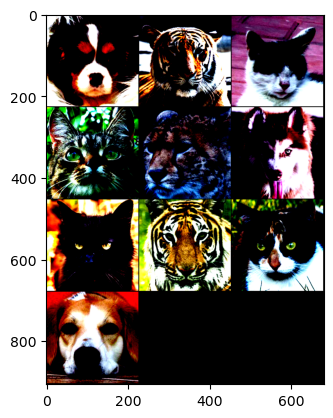

In [6]:
inputs, classes = next(iter(train_loader))
print(inputs.shape)
img = torchvision.utils.make_grid(inputs, nrow = 3)
img = img.numpy().transpose((1, 2, 0)) 
plt.imshow(img)

In [7]:
class CNN(torch.nn.Module): 
    def __init__(self, num_classes=3): 
        super().__init__() 
        self.model = torch.nn.Sequential( 
            #Input = 3 x 32 x 32, Output = 32 x 32 x 32 
            torch.nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3, padding = 1),  
            torch.nn.ReLU(), 
            #Input = 32 x 32 x 32, Output = 32 x 16 x 16 
            torch.nn.MaxPool2d(kernel_size=2), 
  
            #Input = 32 x 16 x 16, Output = 64 x 16 x 16 
            torch.nn.Conv2d(in_channels = 6, out_channels = 6, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(), 
            #Input = 64 x 16 x 16, Output = 64 x 8 x 8 
            torch.nn.MaxPool2d(kernel_size=2), 
              
            #Input = 64 x 8 x 8, Output = 64 x 8 x 8 
            torch.nn.Conv2d(in_channels = 6, out_channels = 6, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(), 
            #Input = 64 x 8 x 8, Output = 64 x 4 x 4 
            torch.nn.MaxPool2d(kernel_size=2), 
  
            torch.nn.Flatten(), 
            torch.nn.Linear(4704, 512), 
            torch.nn.ReLU(), 
            torch.nn.Linear(512, num_classes) 
        ) 
  
    def forward(self, x): 
        return self.model(x) 

In [8]:
#гиперпараметры
num_epochs = 3
learning_rate = 0.001
weight_decay = 0.01

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
  

train_loss_list = [] 
import time
t = time.time()
for epoch in range(num_epochs): 
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if i%100==0:
            print('Эпоха ' + str(epoch) + ' из ' + str(num_epochs) + ' Шаг ' +
                  str(i) + ' Ошибка: ', loss.item())
        
print('Time:',time.time() - t)

Epoch 1/3: Эпоха 0 из 3 Шаг 0 Ошибка:  1.0959486961364746
Эпоха 0 из 3 Шаг 100 Ошибка:  1.0263023376464844
Epoch 2/3: Эпоха 1 из 3 Шаг 0 Ошибка:  0.8790416717529297
Эпоха 1 из 3 Шаг 100 Ошибка:  0.7123802900314331
Epoch 3/3: Эпоха 2 из 3 Шаг 0 Ошибка:  0.9219967722892761
Эпоха 2 из 3 Шаг 100 Ошибка:  0.3762975335121155
Time: 142.04204297065735


In [9]:
correct_predictions = 0
num_test_samples = len(test_sliced)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = net(images) 
        _, pred_class = torch.max(pred.data, 1) 
        correct_predictions += (pred_class == labels).sum().item()

print('Точность модели: ' + str(100 * correct_predictions / num_test_samples) + '%')

Точность модели: 79.7%


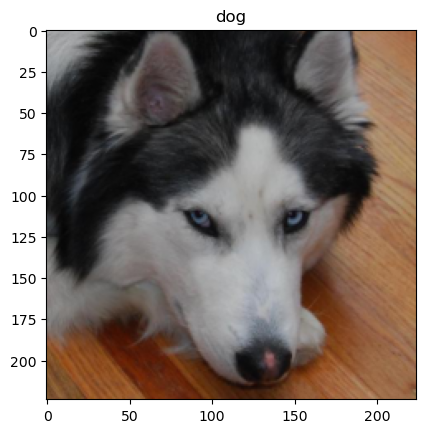

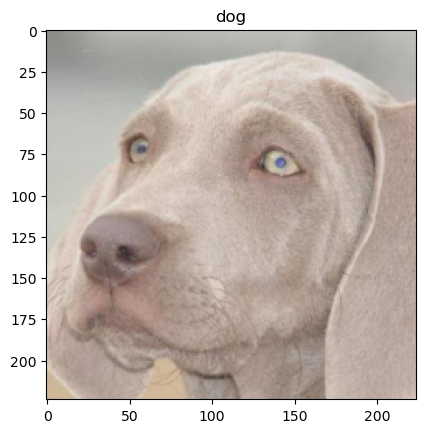

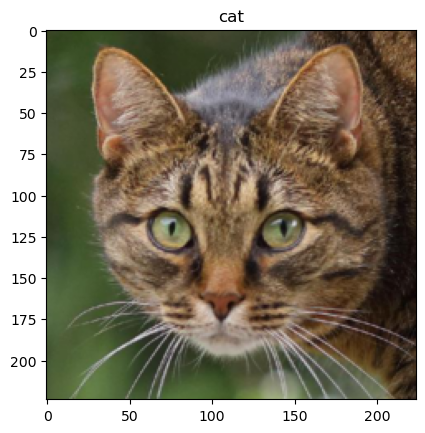

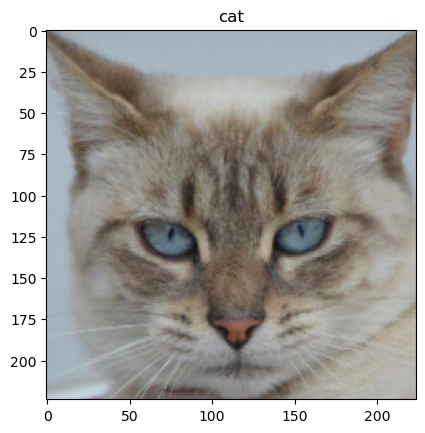

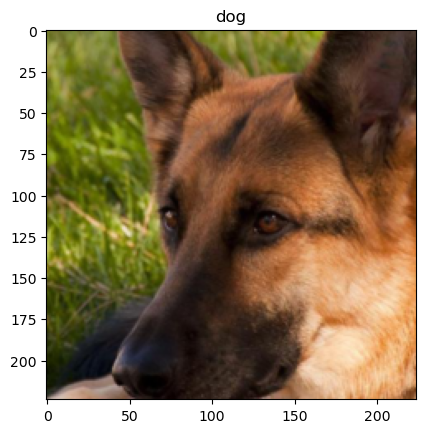

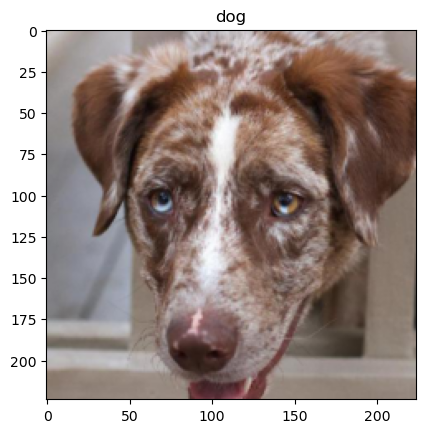

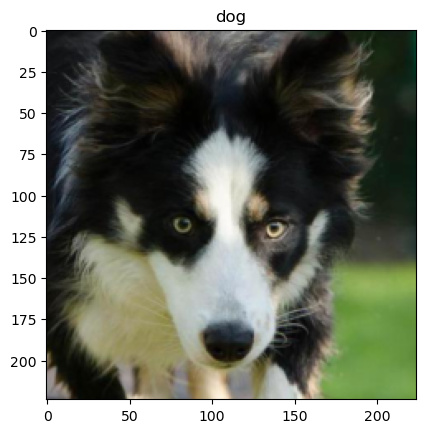

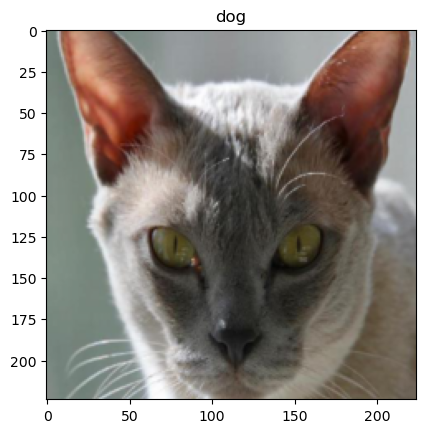

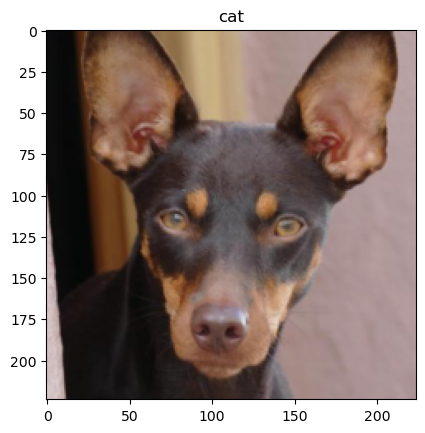

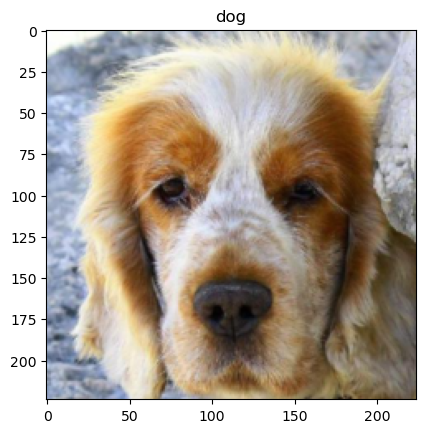

In [10]:
inputs, classes = next(iter(test_loader))
pred = net(inputs.to(device))
_, pred_class = torch.max(pred.data, 1)


for i,j in zip(inputs, pred_class):
    img = i.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(class_names[j])
    plt.pause(2)

In [11]:
torch.save(net.state_dict(), 'net.ckpt')